In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from keras.src.callbacks import EarlyStopping
import random
import numpy as np
import tensorflow as tf
from keras.api.layers import Dense, Dropout
from keras.api.models import Sequential
from keras.api.regularizers import l1, l2
from keras.api.optimizers import Adam

In [2]:
ptc = 0.000059

In [3]:
symbol = "EURUSD=X"
start = "2004-01-01"
end = "2024-08-22"
interval = '1d'

df = yf.download(symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
df.drop(columns=['Adj Close', 'Volume'], inplace=True)
#df.index = df.index.tz_convert('utc')
df['returns'] = np.log(df['Close'].div(df['Close'].shift(1)))
df['day_of_week'] = df.index.dayofweek
df['dir'] = np.where(df['returns'] > 0, 1,0)
df.dropna(inplace=True)

tnx_symbol = "^TNX"

tnx = yf.download(tnx_symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
tnx.drop(columns=['Adj Close', 'Open', 'High', 'Low'], inplace=True)
#df.index = df.index.tz_convert('utc')
tnx.rename(columns={'Close': 'tnx_close', 'Volume': 'tnx_volume'}, inplace=True)
tnx['tnx_returns'] = np.log(tnx['tnx_close'].div(tnx['tnx_close'].shift(1)))
#tnx['tnx_simple_returns'] = tnx['tnx_close'] - tnx['tnx_close'].shift(1)
tnx.dropna(inplace=True)
forex_combined = tnx.join(df, how='outer')

# snp_symbol = "^SPX"
# 
# snp = yf.download(snp_symbol, start, end, interval=interval)
# #df.rename(columns={"Close": "price"}, inplace=True)
# snp.drop(columns=['Adj Close', 'Open', 'High', 'Low'], inplace=True)
# #df.index = df.index.tz_convert('utc')
# snp.rename(columns={'Close': 'snp_close', 'Volume': 'snp_volume'}, inplace=True)
# snp['snp_returns'] = np.log(snp['snp_close'].div(snp['snp_close'].shift(1)))
# snp.dropna(inplace=True)
# forex_combined = snp.join(forex_combined, how='outer')

gold_symbol = "GC=F"

gold = yf.download(gold_symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
gold.drop(columns=['Adj Close', 'Open', 'High', 'Low'], inplace=True)
#df.index = df.index.tz_convert('utc')
gold.rename(columns={'Close': 'gold_close', 'Volume': 'gold_volume'}, inplace=True)
gold['gold_returns'] = np.log(gold['gold_close'].div(gold['gold_close'].shift(1)))
gold.dropna(inplace=True)
forex_combined = gold.join(forex_combined, how='outer')

oil_symbol = "CL=F"

oil = yf.download(oil_symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
oil.drop(columns=['Adj Close', 'Open', 'High', 'Low'], inplace=True)
oil.rename(columns={'Close': 'oil_close', 'Volume': 'oil_volume'}, inplace=True)
oil['oil_returns'] = np.log(oil['oil_close'].div(oil['oil_close'].shift(1)))
oil.dropna(inplace=True)
forex_combined = oil.join(forex_combined, how='outer')

indexes = [
    {"yfinance_ticker": "^SPX", "name": "sp_500"},
#    {"yfinance_ticker": "URTH", "name": "msci_world_index"},
 #   {"yfinance_ticker": "^NDX", "name": "nasdaq_100"},
  #  {"yfinance_ticker": "ACWI", "name": "ftse_all_world_index"},
    {"yfinance_ticker": "^W5000", "name": "wilshire_5000_total_market_index"},
    {"yfinance_ticker": "^N225", "name": "nikkei_225"},
  #  {"yfinance_ticker": "^STOXX50E", "name": "euro_stoxx_50"},
  #  {"yfinance_ticker": "000001.SS", "name": "shanghai_composite_index"},
  #   {"yfinance_ticker": "^HSI", "name": "hang_seng_index"},
  #  {"yfinance_ticker": "EEM", "name": "msci_emerging_markets_index"},
#    {"yfinance_ticker": "^FTSE", "name": "ftse_100"},
    {"yfinance_ticker": "^GDAXI", "name": "dax"},
    {"yfinance_ticker": "^FCHI", "name": "cac_40"},
 #   {"yfinance_ticker": "^GSPTSE", "name": "sp_tsx_composite_index"},
  #  {"yfinance_ticker": "^AXJO", "name": "asx_200"},
  #  {"yfinance_ticker": "^BSESN", "name": "bse_sensex"},
   #  {"yfinance_ticker": "^SSMI", "name": "swiss_market_index"},
 #   {"yfinance_ticker": "^KS11", "name": "kospi"},
    {"yfinance_ticker": "^IBEX", "name": "ibex_35"},
    {"yfinance_ticker": "^RUT", "name": "russell_2000"}
]


def add_index(index_symbol, name):
    index_df = yf.download(index_symbol, start, end, interval=interval)
    index_df.drop(columns=['Adj Close', 'Open', 'High', 'Low'], inplace=True)
    index_df.rename(columns={'Close': f"{name}_close", 'Volume': f"{name}_volume"}, inplace=True)
    index_df[f"{name}_returns"] = np.log(index_df[f"{name}_close"].div(index_df[f"{name}_close"].shift(1)))
    index_df.dropna(inplace=True)
    return index_df

combined_indexes_list = pd.DataFrame()
    
    
features = ['Close', 'returns', 'oil_returns', 'tnx_returns', 'gold_returns', 'gold_volume', 'tnx_volume',]

for index in indexes:
    try:
        df = add_index(index['yfinance_ticker'],  index['name'])
        combined_indexes_list = df.join(combined_indexes_list, how='outer')
  #      features.append(f"{index['name']}_volume")
        features.append(f"{index['name']}_returns")
    except Exception as error:
        print(error)
        print(index)
        
forex_combined = combined_indexes_list.join(forex_combined, how='outer')


forex_clean = forex_combined.copy()
forex_clean.drop(columns=['Open', 'High', 'Low'], inplace=True)


cols = []
for f in features:
    for lag in range(1, 7 + 1):
        col = "{}_lag_{}".format(f, lag)
        forex_clean[col] = forex_clean[f].shift(lag)
    #    cols.append(col)
forex_clean.dropna(inplace=True)

df = forex_clean.copy()

forex_combined

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,russell_2000_close,russell_2000_volume,russell_2000_returns,ibex_35_close,ibex_35_volume,ibex_35_returns,cac_40_close,cac_40_volume,cac_40_returns,dax_close,...,tnx_close,tnx_volume,tnx_returns,Open,High,Low,Close,returns,day_of_week,dir
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.258194,1.262802,1.252693,1.258194,0.000000,4.0,0.0
2004-01-05,568.919983,1.578200e+09,0.014286,7911.399902,114800.0,0.004078,3608.290039,0.0,0.003189,4035.899902,...,4.387,0.0,0.003196,1.263903,1.269406,1.263695,1.268698,0.008313,0.0,1.0
2004-01-06,569.890015,1.494500e+09,0.001704,NaN,NaN,NaN,3595.820068,0.0,-0.003462,4035.439941,...,4.277,0.0,-0.025394,1.268907,1.280803,1.267202,1.272103,0.002681,1.0,1.0
2004-01-07,574.619995,1.704900e+09,0.008266,7913.700195,237400.0,0.000291,3563.510010,0.0,-0.009026,4004.399902,...,4.246,0.0,-0.007274,1.272394,1.273999,1.262499,1.264095,-0.006315,2.0,0.0
2004-01-08,579.619995,1.868400e+09,0.008664,7943.399902,193000.0,0.003746,3592.729980,0.0,0.008166,4045.429932,...,4.249,0.0,0.000706,1.264095,1.278707,1.256502,1.277498,0.010547,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-15,2135.469971,3.723310e+09,0.024244,10885.599609,77126200.0,0.012256,7423.370117,48261500.0,0.012199,18183.240234,...,3.926,0.0,0.027371,1.101322,1.101686,1.095050,1.101322,0.001475,3.0,1.0
2024-08-16,2141.919922,3.357690e+09,0.003016,10949.700195,68792600.0,0.005871,7449.700195,49398000.0,0.003541,18322.400391,...,3.892,0.0,-0.008698,1.097273,1.100437,1.097370,1.097273,-0.003683,4.0,0.0
2024-08-19,2167.500000,3.222050e+09,0.011872,11102.500000,76898300.0,0.013858,7484.169922,9965800.0,0.004616,18421.689453,...,3.867,0.0,-0.006444,1.102499,1.107260,1.102390,1.102499,0.004752,0.0,1.0


In [4]:
def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def cw(df):
    c0, c1 = np.bincount(df["dir"])
    w0 = (1/c0) * (len(df)) / 2
    w1 = (1/c1) * (len(df)) / 2
    return {0:w0, 1:w1}

In [5]:
split = int(len(df)* 0.8)
train = df.iloc[:split].copy()
test = df.iloc[split:].copy()
mu, std = train.mean(), train.std()
train_standardized = (train-mu) / std

In [6]:
column_headers = list(df.columns.values)
features_to_delete =  [
    'dir', 'oil_close','snp_volume', 'Close', 'snp_close',  'tnx_close', 'oil_volume', 'gold_volume', 'gold_close', 'tnx_volume',
    'returns', 'oil_returns', 'gold_returns', 'tnx_returns', 'snp_returns'
]
for index in indexes:
    features_to_delete.append(f"{index['name']}_returns")
    features_to_delete.append(f"{index['name']}_volume")
    features_to_delete.append(f"{index['name']}_close")

features = [item for item in column_headers if item not in features_to_delete]
features

['day_of_week',
 'Close_lag_1',
 'Close_lag_2',
 'Close_lag_3',
 'Close_lag_4',
 'Close_lag_5',
 'Close_lag_6',
 'Close_lag_7',
 'returns_lag_1',
 'returns_lag_2',
 'returns_lag_3',
 'returns_lag_4',
 'returns_lag_5',
 'returns_lag_6',
 'returns_lag_7',
 'oil_returns_lag_1',
 'oil_returns_lag_2',
 'oil_returns_lag_3',
 'oil_returns_lag_4',
 'oil_returns_lag_5',
 'oil_returns_lag_6',
 'oil_returns_lag_7',
 'tnx_returns_lag_1',
 'tnx_returns_lag_2',
 'tnx_returns_lag_3',
 'tnx_returns_lag_4',
 'tnx_returns_lag_5',
 'tnx_returns_lag_6',
 'tnx_returns_lag_7',
 'gold_returns_lag_1',
 'gold_returns_lag_2',
 'gold_returns_lag_3',
 'gold_returns_lag_4',
 'gold_returns_lag_5',
 'gold_returns_lag_6',
 'gold_returns_lag_7',
 'gold_volume_lag_1',
 'gold_volume_lag_2',
 'gold_volume_lag_3',
 'gold_volume_lag_4',
 'gold_volume_lag_5',
 'gold_volume_lag_6',
 'gold_volume_lag_7',
 'tnx_volume_lag_1',
 'tnx_volume_lag_2',
 'tnx_volume_lag_3',
 'tnx_volume_lag_4',
 'tnx_volume_lag_5',
 'tnx_volume_lag_6

In [7]:
### Parameters
dropout = 0.3

In [8]:
features

['day_of_week',
 'Close_lag_1',
 'Close_lag_2',
 'Close_lag_3',
 'Close_lag_4',
 'Close_lag_5',
 'Close_lag_6',
 'Close_lag_7',
 'returns_lag_1',
 'returns_lag_2',
 'returns_lag_3',
 'returns_lag_4',
 'returns_lag_5',
 'returns_lag_6',
 'returns_lag_7',
 'oil_returns_lag_1',
 'oil_returns_lag_2',
 'oil_returns_lag_3',
 'oil_returns_lag_4',
 'oil_returns_lag_5',
 'oil_returns_lag_6',
 'oil_returns_lag_7',
 'tnx_returns_lag_1',
 'tnx_returns_lag_2',
 'tnx_returns_lag_3',
 'tnx_returns_lag_4',
 'tnx_returns_lag_5',
 'tnx_returns_lag_6',
 'tnx_returns_lag_7',
 'gold_returns_lag_1',
 'gold_returns_lag_2',
 'gold_returns_lag_3',
 'gold_returns_lag_4',
 'gold_returns_lag_5',
 'gold_returns_lag_6',
 'gold_returns_lag_7',
 'gold_volume_lag_1',
 'gold_volume_lag_2',
 'gold_volume_lag_3',
 'gold_volume_lag_4',
 'gold_volume_lag_5',
 'gold_volume_lag_6',
 'gold_volume_lag_7',
 'tnx_volume_lag_1',
 'tnx_volume_lag_2',
 'tnx_volume_lag_3',
 'tnx_volume_lag_4',
 'tnx_volume_lag_5',
 'tnx_volume_lag_6

In [9]:
optimizer = Adam(learning_rate = 0.0001, clipvalue=1.0)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

set_seeds(100)
model = Sequential()
model.add(Dense(32, input_dim = len(features), activity_regularizer = None ,activation = "relu", kernel_regularizer=l2(0.001), )) 
model.add(Dropout(dropout, seed = 100))
model.add(Dense(32, activation = "relu", activity_regularizer = None, kernel_regularizer=l2(0.001),))
model.add(Dense(32, activation = "relu", activity_regularizer = None, kernel_regularizer=l2(0.001),))    
model.add(Dropout(dropout, seed = 100))        
model.add(Dense(1, activation = "sigmoid")) 
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

model.fit(x=train_standardized[features], y=train['dir'], epochs=100, verbose=False,
          validation_split=0.2, shuffle=False, class_weight=cw(train), callbacks=[early_stopping] )


C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


In [10]:
loss_train, accuracy_train =  model.evaluate(train_standardized[features], train['dir'])
predict = model.predict(train_standardized[features])

test_standardized = (test-mu) / std
loss_test, accuracy_test =  model.evaluate(test_standardized[features], test['dir'])
test['probability'] = model.predict(test_standardized[features])
threshold = 0.53
test['position'] = np.where(test.probability < (1-threshold), -1, np.nan)
test['position'] = np.where(test.probability > threshold, 1, test.position)
test['position'] = test.position.ffill()
test['strategy'] = test['position'] * test['returns']
test['creturns'] = test['returns'].cumsum().apply(np.exp)
test['cstrategy'] = test['strategy'].cumsum().apply(np.exp)
test['trades'] = test.position.diff().abs()
test['strategy_net'] = test.strategy - test.trades * ptc
test['cstrategy_net'] = test['strategy_net'].cumsum().apply(np.exp)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6207 - loss: 0.7525
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5435 - loss: 0.7735
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [11]:
print(f"Loss: {loss_train}")
print(f"Accuracy: {accuracy_train}")

Loss: 0.7571991682052612
Accuracy: 0.6117021441459656


In [12]:
print(f"Loss: {loss_test}")
print(f"Accuracy: {accuracy_test}")

Loss: 0.7740193605422974
Accuracy: 0.5307855606079102


<Axes: >

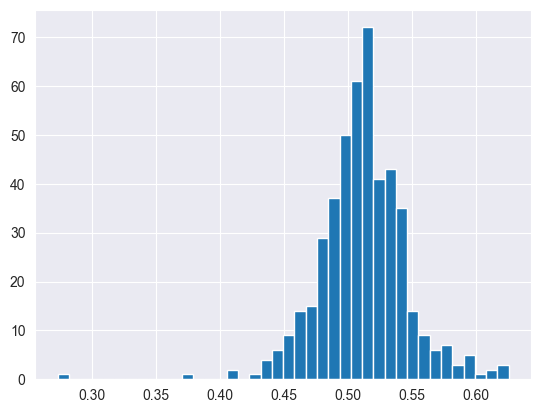

In [13]:
test.probability.hist(bins=40)

<Axes: xlabel='Date'>

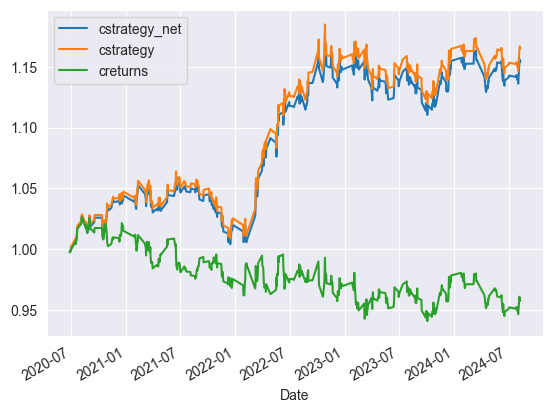

In [14]:
test[['cstrategy_net', 'cstrategy', 'creturns']].plot()

In [15]:
test[['strategy_net']].mean() * 252

strategy_net    0.077192
dtype: float64

In [16]:
test.creturns.corr(test.cstrategy)

-0.7187640943954211

In [17]:
test['prediction_dir'] = np.select(
    [test['probability'] < 0.47, test['probability'] > 0.53],
    [0, 1],
    default=np.nan)

In [18]:
percentage_equal = (test['dir'] == test['prediction_dir']).mean() * 100
percentage_equal

19.745222929936308

In [19]:
print(train['dir'].value_counts())
print(test['dir'].value_counts())

dir
0.0    940
1.0    940
Name: count, dtype: int64
dir
1.0    236
0.0    235
Name: count, dtype: int64


C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Intercept 0.5725101555017383
Prediction_local [0.48205206]
Right: 0.52099043


C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

<Figure size 5000x5000 with 0 Axes>

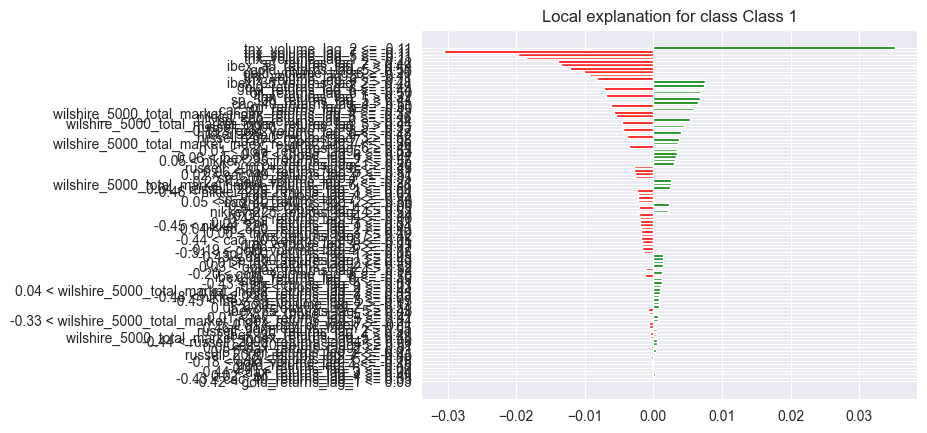

In [20]:
import lime
import lime.lime_tabular
import numpy as np

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(train_standardized[features]),
    mode='classification',
    feature_names=features,
    class_names=['Class 0', 'Class 1'],  # Assuming binary classification
    verbose=True,
    random_state=42
)

# Define a new predict function to return probabilities for both classes
def predict_fn(X):
    probs = model.predict(X)
    return np.hstack((1 - probs, probs))

# Pick a test instance to explain
i = 100  # Index of the test instance
exp = explainer.explain_instance(
    data_row=test_standardized[features].iloc[i],
    predict_fn=predict_fn,  # Modified predict function
    num_features=len(features)
)

plt.figure(figsize=(50, 50))  # Adjust the height (second value) as needed


# Show explanation (as text and visualization)
exp.show_in_notebook(show_table=False)
exp.as_pyplot_figure()
plt.rcParams.update({'font.size': 10})  # Adjust the number as needed
plt.show()

In [21]:
model.save('daily_v70.keras')

In [22]:
import pickle

params = {'mu': mu, 'std': std, 'features': features}
pickle.dump(params, open('params_dailyv70.pkl', 'wb'))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


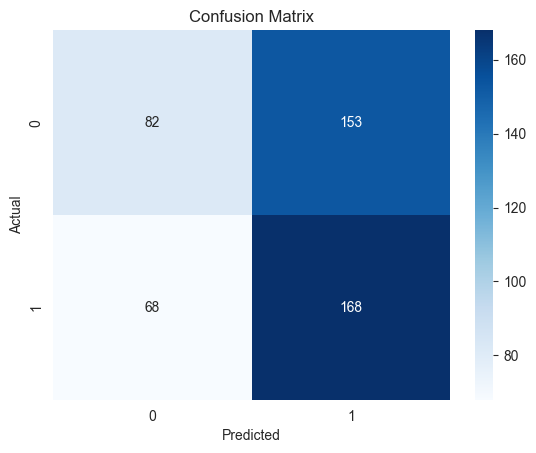

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test['dir']  # Actual labels
y_pred_prob = model.predict(test_standardized[features])
y_pred = np.where(y_pred_prob >= 0.5, 1, 0)  # Convert probabilities to class predictions

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


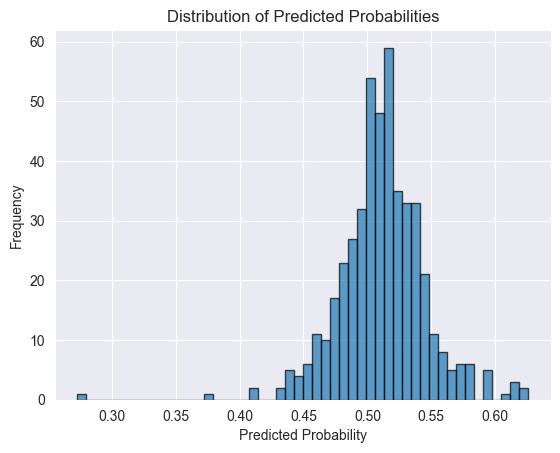

In [24]:
import matplotlib.pyplot as plt

# Predict probabilities
y_pred_prob = model.predict(test_standardized[features])

# Plot histogram of predicted probabilities
plt.hist(y_pred_prob, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

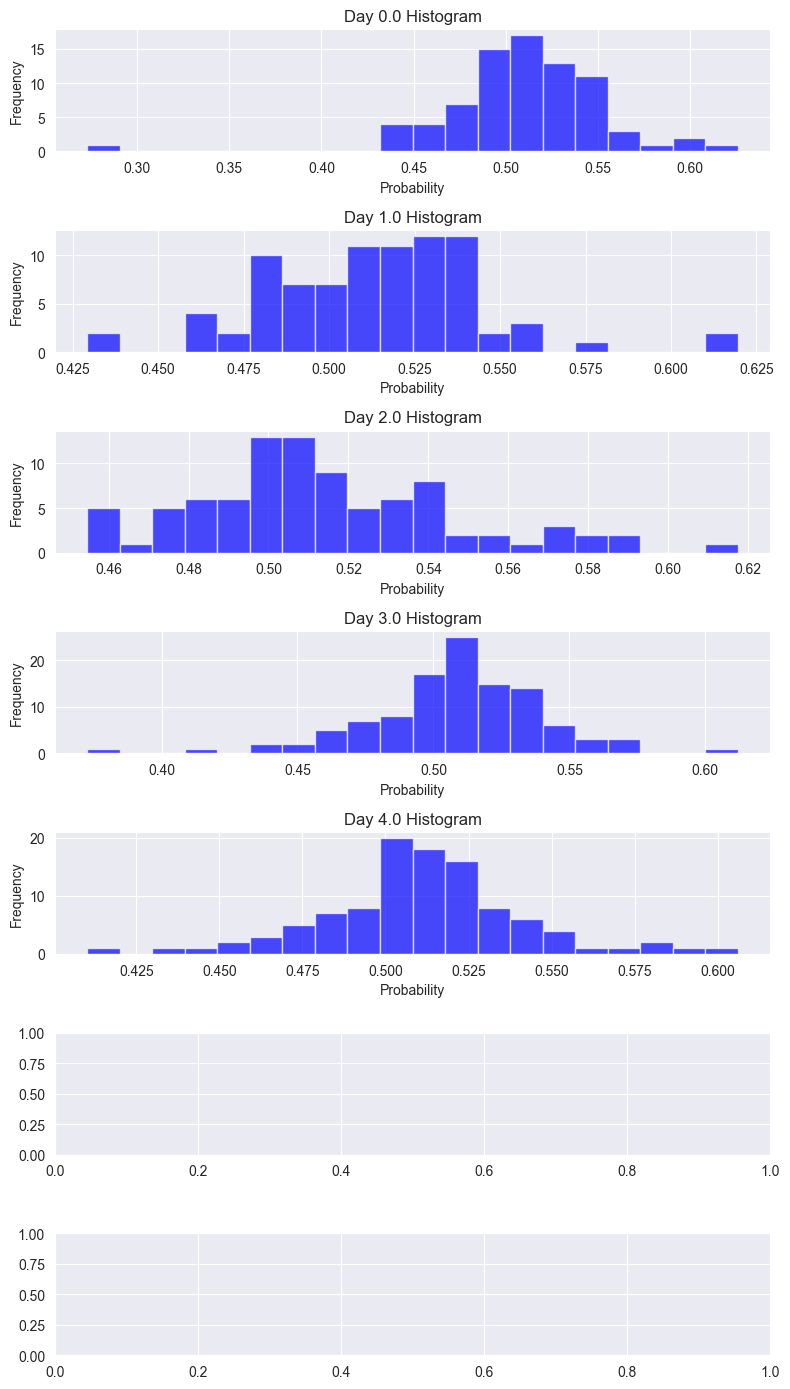

In [25]:
data = test[['day_of_week', 'probability']]

# Group data by day of the week
grouped = data.groupby('day_of_week')

# Create a figure with 7 subplots (one for each day)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 14))

# Plot histograms for each day
for i, (day, group) in enumerate(grouped):
    axes[i].hist(group['probability'], bins=20, color='blue', alpha=0.7)
    axes[i].set_title(f'Day {day} Histogram')
    axes[i].set_xlabel('Probability')
    axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()